<h1>CNN for to detect brain tumors using MRI images</h1>

In [242]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [243]:
# Пути и параметры
DATA_DIR = "data/raw"
TRAIN_DIR = "data/train/"
VAL_DIR = "data/val"
TEST_DIR = "data/test"
categories = ["yes", "no"]
img_size = (224, 224)
batch_size = 16

In [244]:
# Создание директорий
for dir_path in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    os.makedirs(dir_path, exist_ok=True)
    for category in categories:
        os.makedirs(os.path.join(dir_path, category), exist_ok=True)


In [245]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [246]:
# Разделение данных
def split_and_move_data(data_dir, train_dir, val_dir, test_dir, categories):
    for category in categories:
        category_path = os.path.join(data_dir, category)
        images = os.listdir(category_path)
        train_images, temp_images = train_test_split(images, test_size=0.3, random_state=42)
        val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)
        for image_set, target_dir in [(train_images, train_dir), (val_images, val_dir), (test_images, test_dir)]:
            for image in image_set:
                shutil.copy(os.path.join(category_path, image), os.path.join(target_dir, category, image))

split_and_move_data(DATA_DIR, TRAIN_DIR, VAL_DIR, TEST_DIR, categories)

In [247]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range = 0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, target_size=img_size, batch_size=batch_size,
                                                    class_mode='binary')
val_generator = val_datagen.flow_from_directory(VAL_DIR, target_size=img_size, batch_size=batch_size,
                                                class_mode='binary')
test_generator = test_datagen.flow_from_directory(TEST_DIR, target_size=img_size, batch_size=batch_size,
                                                  class_mode='binary')

Found 176 images belonging to 2 classes.
Found 38 images belonging to 2 classes.
Found 39 images belonging to 2 classes.


In [248]:
# Рассчитать веса классов
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

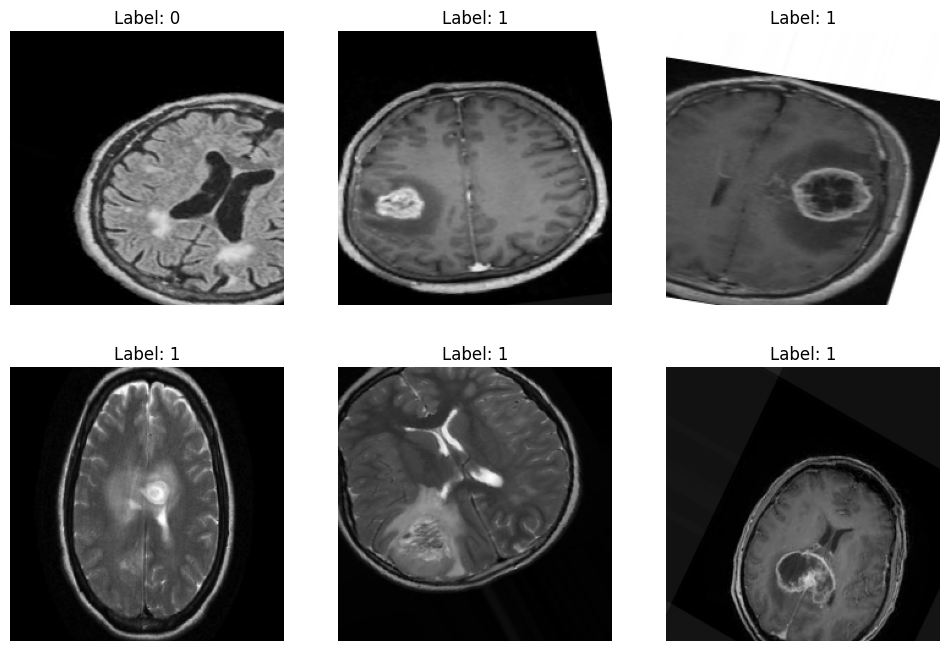

In [249]:
def visualize_images(generator):
    images, labels = next(generator)
    plt.figure(figsize=(12, 8))
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {int(labels[i])}")
        plt.axis('off')
    plt.show()


visualize_images(train_generator)

In [250]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
     Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Для бинарной классификации
])

In [251]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    batch_size=batch_size,
    callbacks=[early_stopping]
)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 547ms/step - accuracy: 0.5775 - loss: 2.2579 - val_accuracy: 0.6053 - val_loss: 0.6266
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 466ms/step - accuracy: 0.6765 - loss: 0.6565 - val_accuracy: 0.6053 - val_loss: 0.6508
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 424ms/step - accuracy: 0.5769 - loss: 0.6538 - val_accuracy: 0.6053 - val_loss: 0.6935
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 421ms/step - accuracy: 0.6068 - loss: 0.6553 - val_accuracy: 0.6053 - val_loss: 0.5841
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 443ms/step - accuracy: 0.6237 - loss: 0.6247 - val_accuracy: 0.8158 - val_loss: 0.6407
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 429ms/step - accuracy: 0.6403 - loss: 0.6542 - val_accuracy: 0.6316 - val_loss: 0.6363
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 436ms/step - accuracy: 0.6262 - loss: 0.6548 - val_accuracy: 0.7632 - val_loss: 0.5841
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 433ms/step - accuracy: 0.6248 - loss: 0.6684 - val_accu

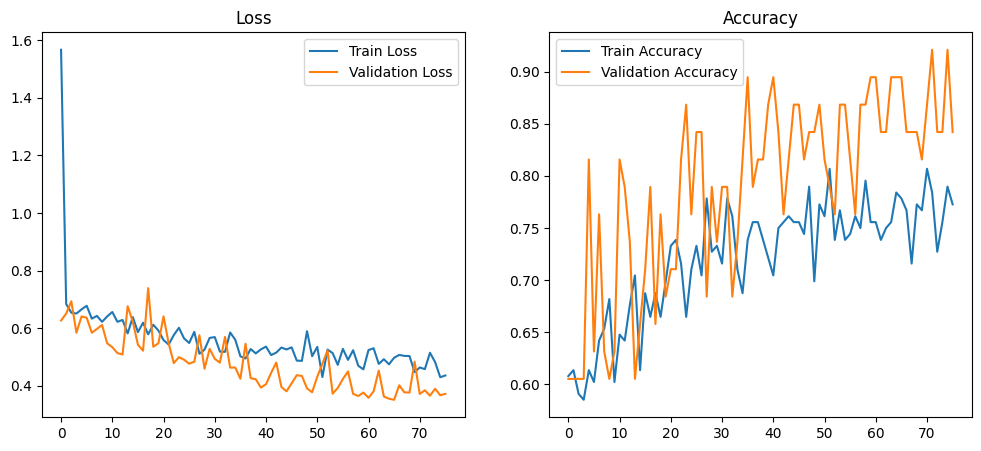

In [252]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.show()


plot_training_history(history)

In [253]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8115 - loss: 0.4704 
Test Accuracy: 0.79
